In [1]:
%matplotlib inline
import sys
sys.path.append("..")


from skimage import io
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

from bsplines.spline_helpers import make_spline
from python.smlm_ctypes import SMLM

In [2]:
INPUT_MOVIE = r'C:\Users\Willem Melching\Dropbox\Thesis\data\z-stack-Beads-AS-Exp-as-stack\sequence-as-stack-Beads-AS-Exp.tif'

POSITIONS = np.array(
    [(25.05051088,20.37593071),
     (93.43403236,28.25086383),
     (43.50957276,71.04008986),
     (28.84621702,119.5179242),
     (90.83092481,111.3964048),
     (122.6776528,62.16889649)]);
movie = io.imread(INPUT_MOVIE)

In [3]:
def lower_intensity(imin, psplit):
    eps = np.finfo(float).eps
    
    epsy = 100*eps;
    tempim = np.round(imin).astype('int32')
    
    diffim = imin - tempim;
    imoutA = np.random.binomial(tempim, psplit);
    imoutA = imoutA + (imoutA / (imin + epsy)) * diffim; 
    imoutB = imin - imoutA;
    
    return imoutA.astype('float64')

In [4]:
def generate_image(smlm, spline, z_index, dx, dy):    
    z_range = np.linspace(-0.75, 0.75, num=151)
    z = z_range[z_index]
    img = np.zeros((31, 31))
    for x in range(1, 32):
        for y in range(1, 32):
            img[y-1][x-1] = smlm.BSpline_EvalSpline(spline, x - dx, y - dy, z)

    return img

def get_img_from_movie(z_index):
    x = int(POSITIONS[0, 0])
    y = int(POSITIONS[0, 1])
    ROI = 15

    img = movie[z_index, y-ROI:y+ROI+1, x-ROI:x+ROI+1]
    return img

Opening C:\Users\Willem Melching\Documents\smlm\x64\Release\smlm_cuda.dll
424.91033657978187


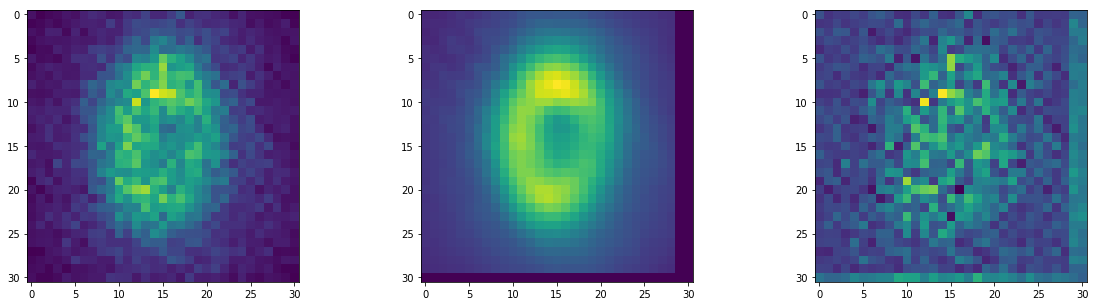

In [41]:
z_index = 5
movie_img = get_img_from_movie(z_index)

with SMLM(debugMode=False) as smlm:
    spline = make_spline(smlm)
    spline_x = make_spline(smlm, spline_name='spline_x')
    spline_y = make_spline(smlm, spline_name='spline_y')
    spline_z = make_spline(smlm, spline_name='spline_z')
    
    
    r_movie, _ = smlm.BSpline_ComputeMLE(np.array([movie_img]),
                                   spline, spline_x, spline_y, spline_z,
                                   startLambdaStep=0.5,
                                   maxIterations=200, cuda=False)
    
    I = r_movie[0][0]
    bg = r_movie[0][1]
    dx = r_movie[0][2] - 15
    dy = r_movie[0][3] - 15
    
    model_img = generate_image(smlm, spline, z_index, dx, dy)
    model_img = I * model_img + bg

    
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(movie_img)
plt.subplot(1,3,2)
plt.imshow(model_img)
plt.subplot(1,3,3)
plt.imshow(movie_img - model_img)
print(np.max(movie_img - model_img))

Opening C:\Users\Willem Melching\Documents\smlm\x64\Release\smlm_cuda.dll
0
2950.6440901381143
1
281.825694179698
2
207.66673126616254
3
182.54233154991732
4
225.0655386887294
5
359.75486547977505
6
153.49856125919004
7
255.07868354802366


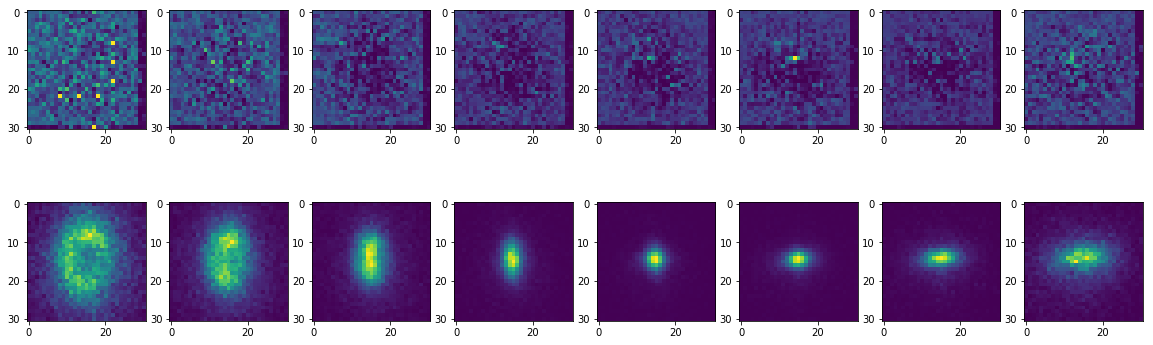

In [55]:
I0s = np.zeros((100, 1))
spline_chis = np.zeros((100, 1))
vector_chis = np.zeros((100, 1))
spline_variances = np.zeros((100, 1))
vector_variances = np.zeros((100, 1))
N = 10

vector = scipy.io.loadmat('vector')

i = 0

N = 8

plt.figure(figsize=(20, 10))
with SMLM(debugMode=False) as smlm:
    spline = make_spline(smlm)

    for z_index in range(0, 151, 20):
        print(i)
        img = get_img_from_movie(z_index)
        model_img = generate_image(smlm, spline, z_index, dx, dy)

        I0 = np.sum(img)

        I = np.max(img)
        bg = np.mean(img[:5, :5])

        # Spline
        expected_img = model_img * (I / np.max(model_img)) + bg
        
        chi = (expected_img - img)**2 / expected_img
        plt.subplot(3, N, i + 1)        
        plt.imshow(chi, vmax=359.75486547977505)
        print(np.max(chi))
        
        
        
        plt.subplot(3, N, i + N + 1)
        plt.imshow(img)
        
        
        i += 1
        
        



In [ ]:
z_index = 70
Is = []
bgs = []

with SMLM(debugMode=False) as smlm:
    spline = make_spline(smlm)
    spline_x = make_spline(smlm, spline_name='spline_x')
    spline_y = make_spline(smlm, spline_name='spline_y')
    spline_z = make_spline(smlm, spline_name='spline_z')
    img = get_img_from_movie(z_index)
    for i in range(20):
        I0 = np.sum(img)
        
        model_img = generate_image(smlm, spline, z_index, dx, dy)
        r_movie, _ = smlm.BSpline_ComputeMLE(np.array([img]),
                           spline, spline_x, spline_y, spline_z,
                           startLambdaStep=0.5,
                           maxIterations=200, cuda=False)
        
        bg_other = np.mean(img[:5, :5])
        print(I0, r_movie[0][0], r_movie[0][1], bg_other)
        Is.append(r_movie[0][0])
        bgs.append(r_movie[0][1])
        img = lower_intensity(img, 0.7)

In [7]:
I0s = np.zeros((100, 1))
spline_chis = np.zeros((100, 1))
vector_chis = np.zeros((100, 1))
spline_variances = np.zeros((100, 1))
vector_variances = np.zeros((100, 1))
N = 10

vector = scipy.io.loadmat('vector')


with SMLM(debugMode=False) as smlm:
    spline = make_spline(smlm)

    for _ in range(N):
        for z_index in range(0, 151):
            img = get_img_from_movie(z_index)
            model_img = generate_image(smlm, spline, z_index, dx, dy)
            vector_img = vector['PSF'][:, :, z_index]

            for i in range(100):
                I0 = np.sum(img)
                I0s[i] += I0
                
                I = np.max(img)
                bg = np.mean(img[:5, :5])

                # Spline
                expected_img = model_img * (I / np.max(model_img)) + bg

                avg = np.average(expected_img)
                expected_img[expected_img < 0.1 * avg] = 0.1 * avg

                chi = np.sum((img[4:27, 4:27] - expected_img[4:27, 4:27])**2 / expected_img[4:27, 4:27])
                spline_chis[i] += chi
                spline_variances[i] += np.sum(1 / expected_img[4:27, 4:27])
                
                # Vector
                expected_img = vector_img * (I / np.max(vector_img)) + bg
                
                avg = np.average(expected_img)
                expected_img[expected_img < 0.1 * avg] = 0.1 * avg

                chi = np.sum((img[4:27, 4:27] - expected_img[4:27, 4:27])**2 / expected_img[4:27, 4:27])
                vector_chis[i] += chi
                vector_variances[i] += np.sum(1 / expected_img[4:27, 4:27])              

                img = lower_intensity(img, 0.9)

print(img[4:27, 4:27].shape)

I0s /= N
spline_chis /= N
spline_variances /= N
vector_chis /= N
vector_variances /= N

vector_variances += 2 * 23 * 23 * 151
spline_variances += 2 * 23 * 23 * 151
expected = np.ones((100, 1)) * 23 * 23 * 151    
        

Opening C:\Users\Willem Melching\Documents\smlm\x64\Release\smlm_cuda.dll
(23, 23)


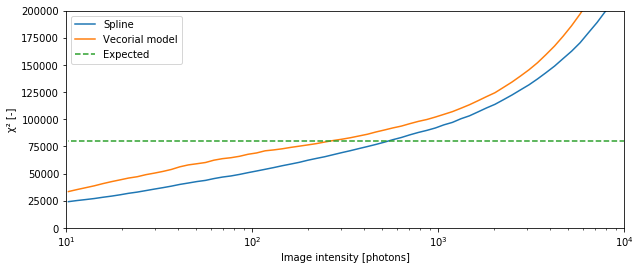

In [17]:
f = plt.figure(figsize=(10, 4))
plt.semilogx(I0s / 151, spline_chis, 'C0-', label='Spline')
plt.semilogx(I0s / 151, vector_chis, 'C1', label='Vecorial model')
plt.semilogx(I0s / 151, expected, 'C2--', label='Expected')

#plt.semilogx(I0s / 151, expected + np.sqrt(spline_variances), 'C0--', label='Expected χ² +/- std spline')
#plt.semilogx(I0s / 151, expected - np.sqrt(spline_variances) , 'C0--')
#plt.semilogx(I0s / 151, expected + np.sqrt(vector_variances), 'C1--', label='Expected χ² +/- std vectorial model')
#plt.semilogx(I0s / 151, expected - np.sqrt(vector_variances) , 'C1--')

plt.xlim([10**1, 10**4])
plt.ylim([0, 2*100000])
plt.ylabel('χ² [-]')
plt.xlabel('Image intensity [photons]')
plt.legend()
f.savefig("./plots/chi_square.pdf", bbox_inches='tight')